### This notebook is used for auROC analysis for neural responses.
To do list:
- [ ] PSTH for individual neurons (-1 to 3s)
- [ ] Bin data with 500-100 ms (arbitrary) for individual neurons
- [ ] Calculate baseline (-5 to -1s before onset? Or just use 1 sec before onset?)
- [ ] Plot distribution of ∆F/F values of both baseline and stimulus onset
- [ ] Calculate ROC with criteria from min to max ∆F/F
- [ ] Calculate AUC of ROC (auROC)
- [ ] For loop for distribution to auROC for each Bin (list append)
- [ ] Stats on auROC trace stimulus onset vs baseline, only >3 bins continuous significant different will be counted as responsive neurons.
- [ ] Count neurons for % of neuron for activated, suppressed, neutral.

For cross correlation
https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import os
import glob

import datetime

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# import sys
# sys.path.append("/Users/hunglo/Dropbox/AG_Johenning_Schmitz/Programming/python/")
# import os
# from figures import plotinscopixtraces


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [4]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events



## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [5]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

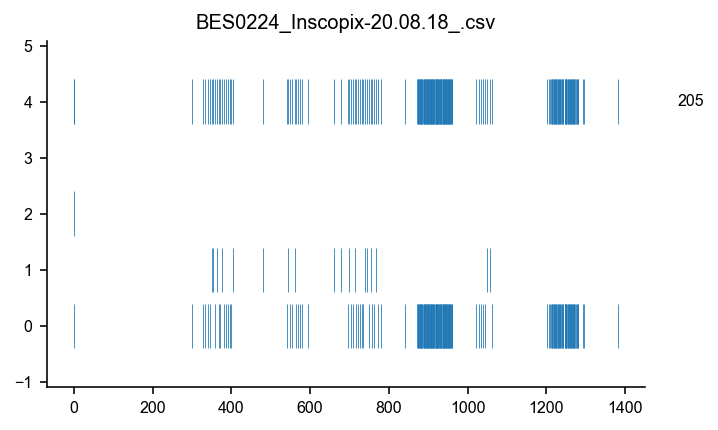

In [27]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?

mouse_id = 'BES0224'
# mouse_id = 'BES0225'
# mouse_id = 'BES0233'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)

# BES0224: 6
# BES0225: -2
# BES0233: 4

idx = 6
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

file_date = result[idx].split('-')[-1].split('.')[0] + result[idx].split('-')[-1].split('.')[1] + result[idx].split('-')[-1].split('.')[2][:-1]

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [28]:
## Load Ca2+ event

event_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/'+mouse_id+file_date+'_celltraces_ED.csv'
df_event=pd.read_csv(event_path, header=0,skiprows=[1],index_col=0)
df_event.head()

sort = 1

if sort == True:
    ## Load Inscopix_GPIO to align Ca2+ data with phenosys
    file_path = event_path[0:-17]+'GPIO.csv'
    sheet=pd.read_csv(file_path, header=[0], index_col=0)
    if mouse_id != 'BES0224':
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' GPIO-1',' GPIO-2',' GPIO-3',' GPIO-4']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
    else:
        ## Change this line for IO1 or IO2
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' IO1',' IO2']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
        # gpiosub=sheet.loc[sheet[' Channel Name']== ' IO1']
    print('Channel selected: '+channels[channel_num])
    Inscopix_GPIO_init = gpiosub[' Value'][300:315].idxmin()

    # Inscopix_GPIO_init
    # Calculate time difference
    if len(P1) == 1:
        if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
            time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
    else:
        if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
            time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
else:
    time_diff = 0
print(time_diff)

# Pivot the dataframe for all time stamps for easy handling
df_spike_binary = df_event.pivot(columns=' Cell Name',values=' Value').fillna(0)
df_spike_binary[df_spike_binary>0] = 1 # Make deconvoluted values to 1
df_spike_binary.index = df_spike_binary.index-time_diff
df_spike_binary.head()

Channel selected:  IO1
12.160996000000011


Cell Name,C0,C1,C10,C100,C101,C102,C103,C104,C105,C106,...,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99
Time (s),,,,,,,,,,,,,,,,,,,,,
-12.110996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.060996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.010996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-11.960996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-11.910996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Strings setups
date = event_path.split('/')[-1].split('_')[0][-6:]
title = mouse_id+' '+date+' CaMKII Neurons'
plot_name = mouse_id+'_'+date+'_CaMKII_'

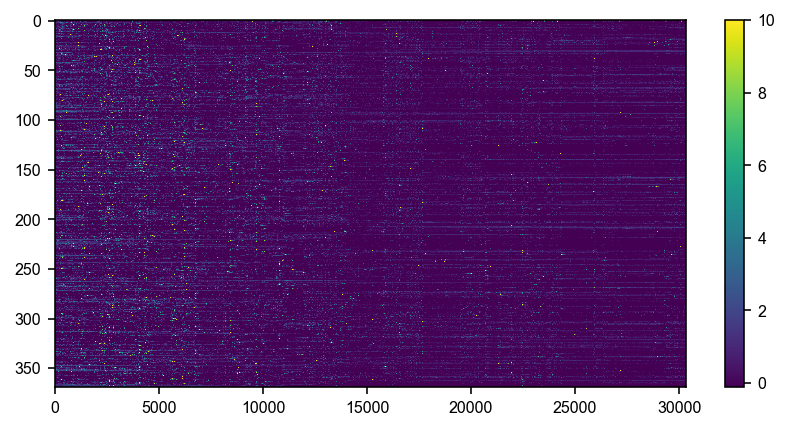

In [30]:
## Use ∆F/F data and bin it with 200 ms/ or 2 s? and take the maximum

plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 8})

from scipy import stats
dff_path = event_path.split('.')[0][:-3] + '.csv'
# dff_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/BES0233201005_celltraces.csv'
df_all = pd.read_csv(dff_path,header=[0,1],index_col=0)
df_accepted = df_all.xs(' accepted',level='Time(s)/Cell Status',axis=1)
df_accepted.index = df_accepted.index-time_diff

# df_sort = df_accepted.reindex(columns=sorted_cell_name)

df_z = df_accepted.apply(stats.zscore,axis=0)
plt.figure(figsize=[6,3])
plt.imshow(df_z.T,aspect='auto',vmin=-0.1, vmax=10, cmap='viridis')
plt.colorbar()
plt.tight_layout()
plt.show()

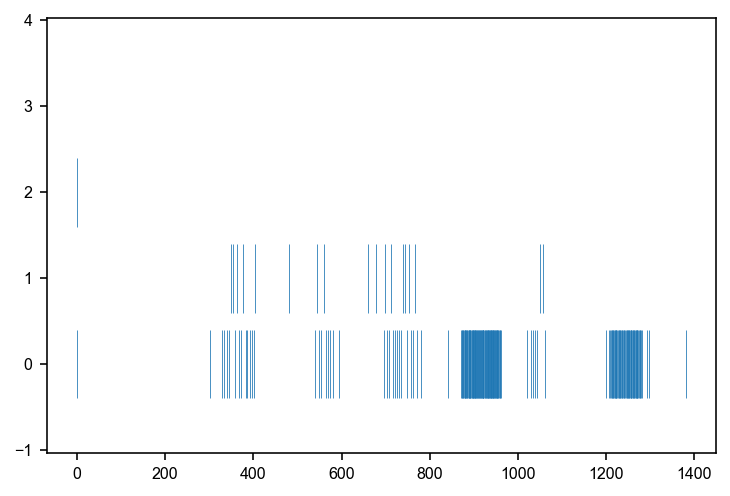

In [31]:
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
# plt.xlim([1200,1210])

In [32]:
## Convert GPIO data to pd dataframe with timestamps as index, easier to remove individual timestamps.
## Make P1, P1C into dateframe

# Or change it to P2, P2A for GPIO3-4

GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
GPIO1_df.columns = ['timestamps', 'value']
GPIO1_df = GPIO1_df.set_index('timestamps')
GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
GPIO1C_df.columns = ['timestamps', 'value']
GPIO1C_df = GPIO1C_df.set_index('timestamps')

# binging_round_time = [GPIO1_df[800:1000].index.values[1], # remove initial pump activation
#                       GPIO1_df[800:1000].index.values[-1]]
## New capture single licks in rounds and remove initial pumps.
# Get single lick trials
# Get GPIO1 and GPIO1C timestamp for 4 sec time window.
# Define first single lick round
# From 300-450 sec for first lick round
# s_lick_p1_1 = GPIO1_df[300:450].index.values[1:] # no init
s_lick_p1_1 = np.array([])
s_lick_p1_2 = GPIO1_df[450:600].index.values[0:] # no init
# s_lick_p1_2 = np.array([])
# s_lick_p1_3 = GPIO1_df[800:1000].index.values[1:] # remove init
s_lick_p1_3 = np.array([])
# s_lick_p1_4 = GPIO1_df[1000:1200].index.values[1:] # no init
s_lick_p1_4 = np.array([])
s_lick_p1_5 = GPIO1_df[1350:].index.values[0:] # no init
# s_lick_p1_5 = np.array([])

import itertools

s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
s_lick_p1_flatten 

# for pump 1c (water) and remove init
# s_lick_p1C_1 = GPIO1C_df[300:450].index.values[0:]
s_lick_p1C_1 = np.array([])
s_lick_p1C_2 = GPIO1C_df[450:600].index.values[1:]
# s_lick_p1C_2 = np.array([])
# s_lick_p1C_3 = GPIO1C_df[800:1000].index.values[0:]
s_lick_p1C_3 = np.array([])
# s_lick_p1C_4 = GPIO1C_df[1000:1200].index.values[0:]
s_lick_p1C_4 = np.array([])
s_lick_p1C_5 = GPIO1C_df[1350:].index.values[1:]
# s_lick_p1C_5 = np.array([])

s_lick_p1C_combined = [s_lick_p1C_1, s_lick_p1C_2, s_lick_p1C_3, s_lick_p1C_4, s_lick_p1C_5]
s_lick_p1C_flatten = list(itertools.chain.from_iterable(s_lick_p1C_combined))
s_lick_p1C_flatten 

[545.001005, 560.721001]

In [13]:
## Design matrix of Ca2+ traces -1 to 3 sec after the onset for one neuron
from sklearn.metrics import auc

PSTH_trace = pd.DataFrame()
PSTH_cell_mean = pd.DataFrame()
cellset = df_z.columns[:]
## Try to use if we don't use z-score but A.U.
data = df_z.copy()
# data = df_accepted.copy()

auc_total_all_cell = pd.DataFrame()
for cell in cellset[:]:
    PSTH_trace = pd.DataFrame()
    df_baseline = pd.DataFrame()
    for trial,time in enumerate(s_lick_p1_flatten):
        PSTH_trace[trial]=data[cell][time-1:time+3].reset_index(drop=True)
        # df_baseline[trial]=df_z[cell][time-1:time].reset_index(drop=True)
    # Baseline is just the 1st second (20 rows) of PSTH_trace 
    df_baseline=PSTH_trace[0:20]

    # Then bin data with 100 ms (2 frames)
    PSTH_bin = PSTH_trace.groupby(PSTH_trace.index // 2).mean()
    PSTH_cell_mean[cell] = PSTH_bin.mean(axis=1)
    df_baseline_bin = df_baseline.groupby(df_baseline.index//2).mean()

    auc_total = []
    baseline = df_baseline_bin.values.flatten() # move to here

    for i in PSTH_bin.index:
        # baseline = df_baseline_bin.values.flatten() # move outside the for loop since it's all the same and more efficient
        stimulus = PSTH_bin.iloc[i,:].values
        
        # Create an arithmetic sequence with 5000 items as cutoffs
        # Starting from the minimum of all observations
        # Stopping at the max
        pool = [*baseline, *stimulus]
        steps = 100
        criteria = [min(pool) + (j*(max(pool)-min(pool))/steps) for j in range(steps)]
        # criteria[-1] = criteria[-1] - 1e-12 # modify the max value to slighter lesser value, so baseline/stimulus will be larger than the max of criteria
        # Initiate results as empty lists
        pbase = []
        pstim = []
        # Calculate P(above threshold) for each cutoff
        for cri in criteria:
            pbase.append(sum(baseline >= cri)/len(baseline))
            pstim.append(sum(stimulus >= cri)/len(stimulus))
            # Calculate AUC (sklearn implementation)
        auc_ = auc(x = pbase, y = pstim)
        auc_total.append(auc_)
        # Visual checking
        # plt.figure(figsize=[1.5,1.5])
        # plt.scatter(x = pbase, y = pstim, alpha=0.5,s=4); plt.plot([0,1],[0,1],ls=':',color='C1')
        # plt.title('Bin:'+str(i) +'/ AUC:'+ str(round(auc_,2)),fontsize=8)
        # plt.xticks([0,1]); plt.yticks([0,1]); sns.despine(); plt.tight_layout(); plt.show()
    auc_total_all_cell[cell] = auc_total


In [14]:
## The same for water
## Design matrix of Ca2+ traces -1 to 3 sec after the onset for one neuron

from sklearn.metrics import auc

PSTH_trace = pd.DataFrame()
data = df_accepted.copy()
auc_total_all_cell_water = pd.DataFrame()
data = df_z.copy()
# data = df_accepted.copy()

for cell in cellset:
    PSTH_trace = pd.DataFrame()
    df_baseline = pd.DataFrame()
    for trial,time in enumerate(s_lick_p1C_flatten):
        PSTH_trace[trial]=data[cell][time-1:time+3].reset_index(drop=True)
        # df_baseline[trial]=df_z[cell][time-1:time].reset_index(drop=True)
    df_baseline=PSTH_trace[0:20]
    ## Now compute the baseline from -5 to -1 sec before drinking round starts.
    # Change baseline to 1 min before drinking starts, seems it represents more for the overall activity. Still bin it to 100 ms.
    # Then bin data with 100 ms (2 frames)
    PSTH_bin = PSTH_trace.groupby(PSTH_trace.index // 2).mean()
    # PSTH_cell_mean[cell] = PSTH_bin.mean(axis=1)
    df_baseline_bin = df_baseline.groupby(df_baseline.index//2).mean()

    auc_total = []
    ## remember to replace the C0 to individual cells
    baseline = df_baseline_bin.values.flatten()              # This is -1 to 0 baseline, only binned

    for i in PSTH_bin.index:
        # baseline = df_baseline_bin.values.flattern #df_baseline_bin.mean(axis=0)(axis=0)r loop since it's all the same
        stimulus = PSTH_bin.iloc[i,:].values
        # Create an arithmetic sequence with 5000 items as cutoffs
        # Starting from the minimum of all observations
        # Stopping at the max
        pool = [*baseline, *stimulus]
        steps = 100
        criteria = [min(pool) + (i*(max(pool)-min(pool))/steps) for i in range(steps)]

        # Initiate results as empty lists
        pbase = []
        pstim = []
        # Calculate P(above threshold) for each cutoff
        for cri in criteria:
            pbase.append(sum(baseline >= cri)/len(baseline))
            pstim.append(sum(stimulus >= cri)/len(stimulus))
            # Calculate AUC (sklearn implementation)
        auc_ = auc(x = pbase, y = pstim)
        auc_total.append(auc_)
    auc_total_all_cell_water[cell] = auc_total

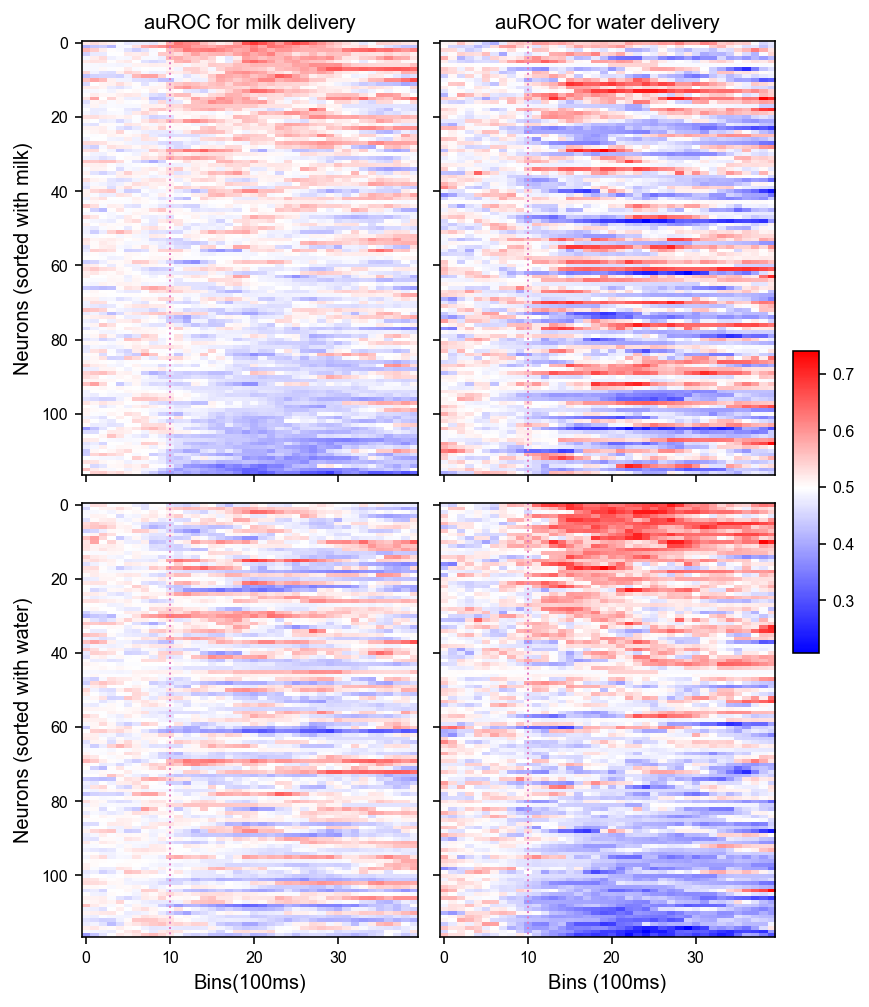

In [15]:
isort = np.argsort(-auc_total_all_cell[10:30].mean(axis=0))
isort_w = np.argsort(-auc_total_all_cell_water[10:30].mean(axis=0))

elev_min = np.min([np.min(np.min(auc_total_all_cell)),np.min(np.min(auc_total_all_cell_water))])
elev_max = np.max([np.max(np.max(auc_total_all_cell)),np.max(np.max(auc_total_all_cell_water))])
# elev_min = 
mid_val=0.5

fig, ([ax0,ax1],[ax2,ax3]) = plt.subplots(nrows=2,ncols=2, figsize=[6,7],sharex=True,sharey=True)

# auROC for Milk neurons (sort with milk and water [ax0,ax2])

im = ax0.imshow(auc_total_all_cell.iloc[:,isort].T,aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax0.set_title('auROC for milk delivery',fontsize=10)
ax0.vlines(x=10,ymin=-0.5,ymax=auc_total_all_cell.shape[1]-0.5,ls=':',color='C6',lw=1)
ax0.set_ylabel('Neurons (sorted with milk)',fontsize=10)
# ax0.set_xlabel('Bins(100ms)',fontsize=10)

ax2.imshow(auc_total_all_cell.iloc[:,isort_w].T,aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# ax2.set_title('auROC for milk delivery',fontsize=10)
ax2.vlines(x=10,ymin=-0.5,ymax=auc_total_all_cell.shape[1]-0.5,ls=':',color='C6',lw=1)
ax2.set_ylabel('Neurons (sorted with water)',fontsize=10)
ax2.set_xlabel('Bins(100ms)',fontsize=10)

# auROC for water neurons (sort with milk and water [ax0,ax2])

ax1.imshow(auc_total_all_cell_water.iloc[:,isort].T,aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax1.set_title('auROC for water delivery',fontsize=10)
ax1.vlines(x=10,ymin=-0.5,ymax=auc_total_all_cell_water.shape[1]-0.5,ls=':',color='C6',lw=1)
# ax1.set_ylabel('Neurons',fontsize=10)
# ax1.set_xlabel('Bins (100ms)',fontsize=10)

ax3.imshow(auc_total_all_cell_water.iloc[:,isort_w].T,aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# ax3.set_title('auROC for water delivery',fontsize=10)
ax3.vlines(x=10,ymin=-0.5,ymax=auc_total_all_cell_water.shape[1]-0.5,ls=':',color='C6',lw=1)
# ax3.set_ylabel('Neurons',fontsize=10)
ax3.set_xlabel('Bins (100ms)',fontsize=10)

# sns.despine()

save_file_name = dff_path.split('.')[0].split('/')[-1].split('_')[0]
# plt.title(save_file_name,fontsize=10)

plt.tight_layout()

# fig.colorbar(im,shrink=0.6,ax=axes.ravel().tolist())
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.03, 0.3])
fig.colorbar(im, cax=cbar_ax,shrink=0.8)


# plt.savefig
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/milk_water_matirx_'+save_file_name+'.pdf',dpi=600,transparent=True)

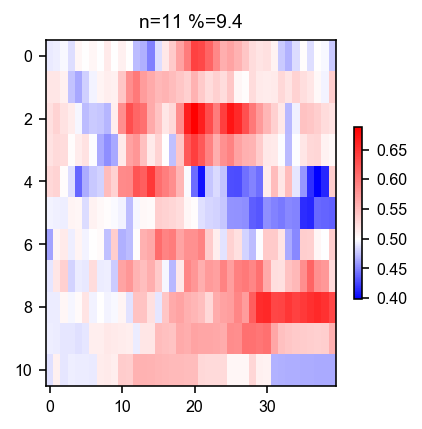

In [16]:
## Select positive milk neurons
## Now with baseline mean and std instead of 0.5 (but also close to 0.5)
threshold_high = np.mean(auc_total_all_cell[0:10]) + np.std(auc_total_all_cell[0:10])*3.5
# threshold_high = 0.5 + np.std(auc_total_all_cell[0:10])*2.5
# threshold_high = 0.5 + np.std(auc_total_all_cell)*2

idx_positive = []
for cell in auc_total_all_cell.columns[:]:
    j_temp = []
    for j in range(10,25):
        if auc_total_all_cell[cell][j]>threshold_high[cell]:
            j_temp.append(j)
    # print(j_temp)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                # print(cell,j_temp)
                idx_positive.append(cell)
                break
# print(idx_positive)
elev_min=np.min(auc_total_all_cell[idx_positive].values.flatten())
elev_max=np.max(auc_total_all_cell[idx_positive].values.flatten())
mid_val=0.5
n = str(len(idx_positive))
perc = str(round(len(idx_positive)/auc_total_all_cell.shape[1]*100,2))
plt.figure(figsize=[3,3])
plt.imshow(auc_total_all_cell[idx_positive].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.title('n='+n+' %='+perc)
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()


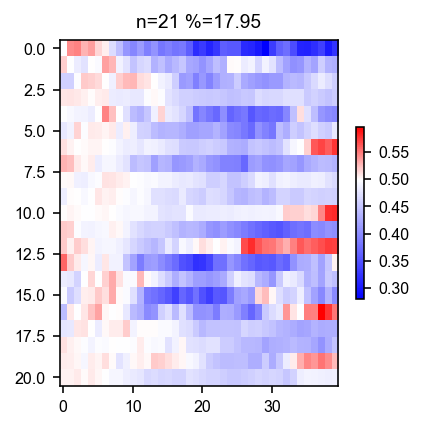

In [17]:
## Now for negative milk neurons
## Now with baseline mean and std instead of 0.5 (but also close to 0.5)
threshold_low = np.mean(auc_total_all_cell[0:10]) - np.std(auc_total_all_cell[0:10])*3.5
# threshold_low = 0.5 - np.std(auc_total_all_cell[0:10])*2.5
# threshold_high = 0.5 + np.std(auc_total_all_cell)*2

idx_negative = []
for cell in auc_total_all_cell.columns[:]:
    j_temp = []
    for j in range(10,25):
        if auc_total_all_cell[cell][j]<threshold_low[cell]:
            j_temp.append(j)
    # print(j_temp)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                # print(cell,j_temp)
                idx_negative.append(cell)
                break
# print(idx_positive)
elev_min=np.min(auc_total_all_cell[idx_negative].values.flatten())
elev_max=np.max(auc_total_all_cell[idx_negative].values.flatten())
mid_val=0.5
# print(len(idx_negative),len(idx_negative)/auc_total_all_cell.shape[1]*100)
n = str(len(idx_negative))
perc = str(round(len(idx_negative)/auc_total_all_cell.shape[1]*100,2))

# sns.heatmap(auc_total_all_cell[idx_positive].T,cmap='bwr',center=0.5)
plt.figure(figsize=[3,3])
plt.title('n='+n+' %='+perc)
plt.imshow(auc_total_all_cell[idx_negative].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar(shrink=0.5)
plt.tight_layout()

22 18.803418803418804


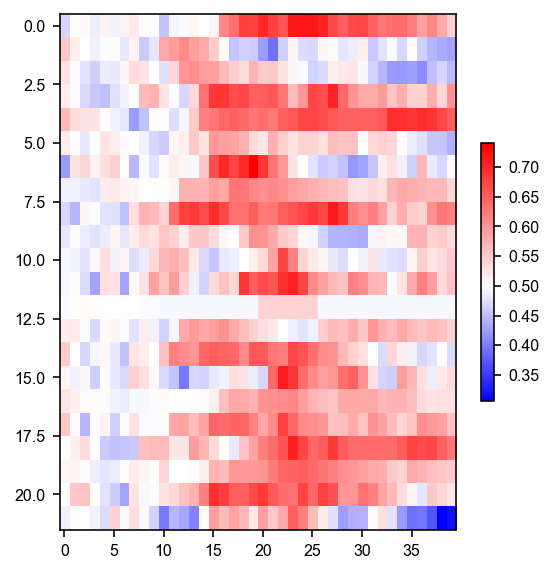

In [18]:
## Same for water neurons
## Positive index for water neurons
## Now with baseline mean and std instead of 0.5 (but also close to 0.5)
threshold_high = np.mean(auc_total_all_cell_water[0:10]) + np.std(auc_total_all_cell_water[0:10])*3.5
data = auc_total_all_cell_water.copy()

# threshold_high = 0.5 + np.std(data[0:10])*2.5

idx_positive_w = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]>threshold_high[cell]:
            j_temp.append(j)
    # print(j_temp)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                # print(cell,j_temp)
                idx_positive_w.append(cell)
                break

elev_min=np.min(data[idx_positive_w].values.flatten())
elev_max=np.max(data[idx_positive_w].values.flatten())
mid_val=0.5
print(len(idx_positive_w),len(idx_positive_w)/data.shape[1]*100)
# sns.heatmap(auc_total_all_cell[idx_positive].T,cmap='bwr',center=0.5)
plt.figure(figsize=[4,4])
plt.imshow(data[idx_positive_w].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar(shrink=0.5)
plt.tight_layout()


20 17.094017094017094


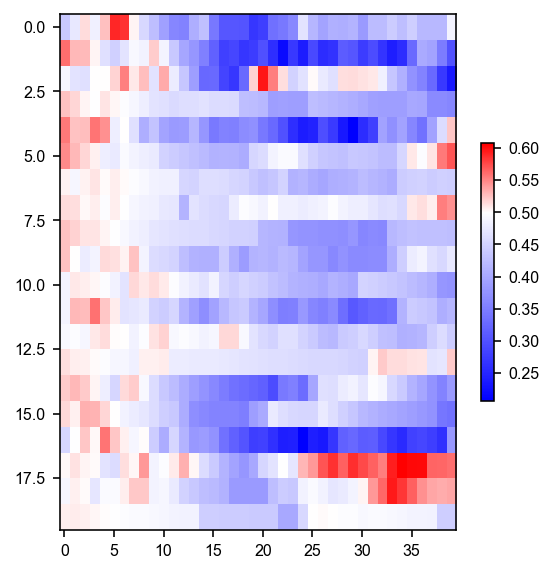

In [19]:
## Now for water negative neurons

## Now with baseline mean and std instead of 0.5 (but also close to 0.5)
# Since this prevents more of low baseline neurons 

threshold_low = np.mean(auc_total_all_cell_water[0:10]) - np.std(auc_total_all_cell_water[0:10])*3.5

data = auc_total_all_cell_water.copy()

idx_negative_w = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]<threshold_low[cell]:
            j_temp.append(j)
    # print(j_temp)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                # print(cell,j_temp)
                idx_negative_w.append(cell)
                break

elev_min=np.min(data[idx_negative_w].values.flatten())
elev_max=np.max(data[idx_negative_w].values.flatten())
mid_val=0.5
print(len(idx_negative_w),len(idx_negative_w)/data.shape[1]*100)
# sns.heatmap(auc_total_all_cell[idx_positive].T,cmap='bwr',center=0.5)
plt.figure(figsize=[4,4])
plt.imshow(data[idx_negative_w].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.colorbar(shrink=0.5)
plt.tight_layout()


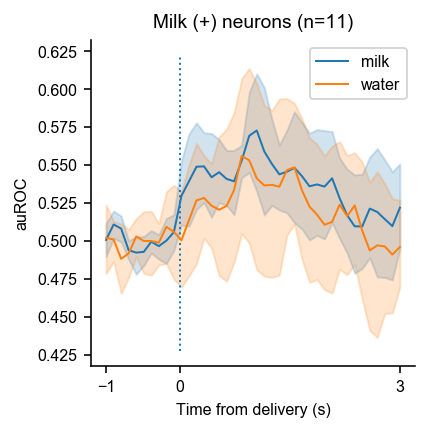

In [20]:
## Plot average line with CI (sns)
data = auc_total_all_cell[idx_positive].copy()
data_w = auc_total_all_cell_water[idx_positive].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')

# plt.legend(title='Drink')
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Milk (+) neurons (n='+str(len(idx_positive))+')')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_positive_neuron'+save_file_name+'.pdf',dpi=300,transparent=True)

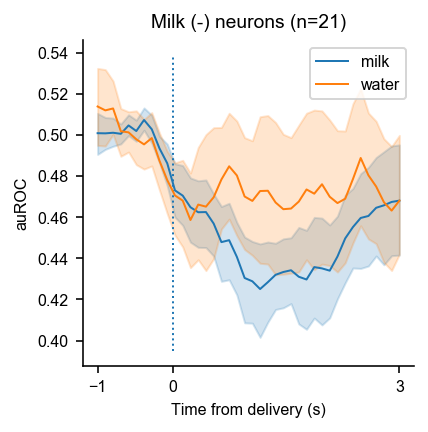

In [21]:
## Plot average line with CI (sns)
data = auc_total_all_cell[idx_negative].copy()
data_w = auc_total_all_cell_water[idx_negative].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')

# plt.legend(title='Drink')
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Milk (-) neurons (n='+str(len(idx_negative))+')')
plt.tight_layout()

plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_negative_neuron'+save_file_name+'.pdf',dpi=300,transparent=True)

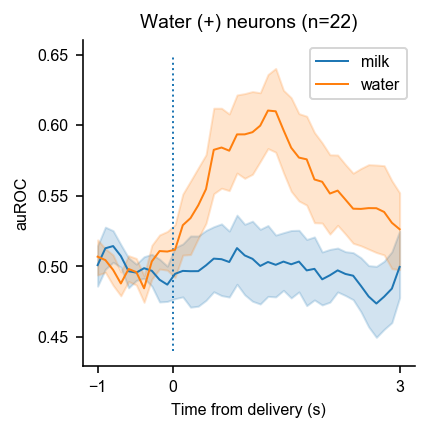

In [22]:
## Now for water positive cells
## Plot average line with CI (sns)
data = auc_total_all_cell[idx_positive_w].copy()
data_w = auc_total_all_cell_water[idx_positive_w].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')
# plt.legend(frameon=False)
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Water (+) neurons (n='+str(len(idx_positive_w))+')')
plt.tight_layout()
# plt.savefig('/Users/hunglo/Desktop/auROC/auROC_water_positive_neuron.pdf',dpi=300,transparent=True)
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_positive_neuron'+save_file_name+'.pdf',dpi=300,transparent=True)

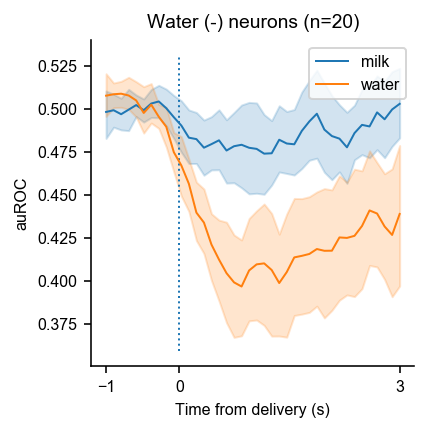

In [23]:
## Plotting for water negative neurons
## Plot average line with CI (sns)
data = auc_total_all_cell[idx_negative_w].copy()
data_w = auc_total_all_cell_water[idx_negative_w].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')
# plt.legend(frameon=False)
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Water (-) neurons (n='+str(len(idx_negative_w))+')')
plt.tight_layout()
# plt.savefig('/Users/hunglo/Desktop/auROC/auROC_water_negative_neuron.pdf',dpi=300,transparent=True)
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_negative_neuron'+save_file_name+'.pdf',dpi=300,transparent=True)

In [24]:
## Save auROC data for future use
# # save to npy
# np.save('/Users/hunglo/Desktop/auROC/auROC.npy',auc_total_all_cell)
# save to csv file
np.savetxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_'+save_file_name+'.csv',auc_total_all_cell, delimiter=',')
np.savetxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_'+save_file_name+'.csv',auc_total_all_cell_water, delimiter=',')


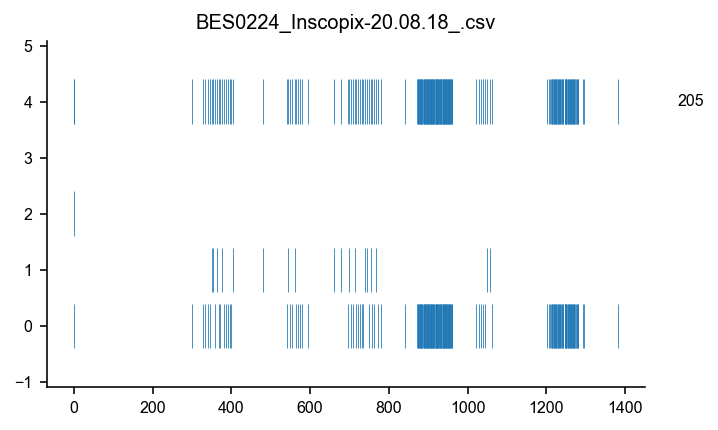

In [33]:

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [34]:
## Now do the same for binge bouts (each binge bout as 1 trial)
## Convert GPIO data to pd dataframe with timestamps as index, easier to remove individual timestamps.
## Make P1, P1C into dateframe

# Convert P1/P1C to dataframe
if P2.size==0 or P2A.size==0:
    # print('work')
    GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')
else:
    GPIO1_df = pd.DataFrame([P2,np.ones(len(P2))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P2A,np.ones(len(P2A))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')

# Define binge rounds
binge_p1_round_1 = GPIO1_df[800:1000].index.values[1]
binge_p1_round_2 = GPIO1_df[1200:1350].index.values[1]

# binge_round_2 = GPIO1_df[1000:1200].index.values[1:]
# binge_p1_round_2 = np.array([])
# binge_p1_round_3 = np.array([])

import itertools

binge_p1_combined = [binge_p1_round_1,binge_p1_round_2]
binge_p1_combined
# binge_p1_flatten = list(itertools.chain.from_iterable(binge_p1_combined))
# binge_p1_flatten

# s_lick_p1_combined = [s_lick_p1_1, s_lick_p1_2, s_lick_p1_3, s_lick_p1_4, s_lick_p1_5]
# s_lick_p1_flatten = list(itertools.chain.from_iterable(s_lick_p1_combined))
# s_lick_p1_flatten 

# # for pump 1c (water) and remove init
# s_lick_p1C_1 = GPIO1C_df[300:450].index.values[0:]
# s_lick_p1C_2 = GPIO1C_df[450:600].index.values[0:]
# # s_lick_p1C_2 = np.array([])
# # s_lick_p1C_3 = GPIO1C_df[800:1000].index.values[0:]
# s_lick_p1C_3 = np.array([])
# s_lick_p1C_4 = GPIO1C_df[1000:1200].index.values[0:]
# # s_lick_p1C_4 = np.array([])
# # s_lick_p1C_5 = GPIO1C_df[1350:].index.values[0:]
# s_lick_p1C_5 = np.array([])

# s_lick_p1C_combined = [s_lick_p1C_1, s_lick_p1C_2, s_lick_p1C_3, s_lick_p1C_4, s_lick_p1C_5]
# s_lick_p1C_flatten = list(itertools.chain.from_iterable(s_lick_p1C_combined))
# s_lick_p1C_flatten 


[871.192005, 1207.302002]

In [38]:
## Design matrix for binging trials
## Design matrix of Ca2+ traces -1 to 3 sec after the onset for one neuron
from sklearn.metrics import auc

PSTH_trace = pd.DataFrame()
PSTH_cell_mean = pd.DataFrame()
cellset = df_z.columns[0:5]

data = df_z.copy()

timestamp = binge_p1_combined

auc_total_all_cell = pd.DataFrame()
for cell in cellset:
    PSTH_trace = pd.DataFrame()
    df_baseline = pd.DataFrame()
    for trial,time in enumerate(timestamp):
        PSTH_trace[trial]=data[cell][time-20:time+20].reset_index(drop=True)
        # print(cell,trial,time)
    PSTH_cell_mean[cell]=PSTH_trace.mean(axis=1)
    df_baseline=PSTH_trace[0:400]

    # Then bin data with 100 ms (2 frames)
    # Now with 200 ms to save time
    PSTH_bin = PSTH_trace.groupby(PSTH_trace.index // 4).mean()
    PSTH_cell_mean[cell] = PSTH_bin.mean(axis=1)
    df_baseline_bin = df_baseline.groupby(df_baseline.index//4).mean()

    auc_total = []
    baseline = df_baseline_bin.values.flatten() # move to here

    for i in PSTH_bin.index:
        stimulus = PSTH_bin.iloc[i,:].values
        pool = [*baseline, *stimulus]
        steps = 50 # 100
        criteria = [min(pool) + (j*(max(pool)-min(pool))/steps) for j in range(steps)]
        # Initiate results as empty lists
        pbase = []
        pstim = []
        # Calculate P(above threshold) for each cutoff
        for cri in criteria:
            pbase.append(sum(baseline >= cri)/len(baseline))
            pstim.append(sum(stimulus >= cri)/len(stimulus))
            # Calculate AUC (sklearn implementation)
        auc_ = auc(x = pbase, y = pstim)
        auc_total.append(auc_)
        print(cell, trial, i, auc_)
    auc_total_all_cell[cell] = auc_total


 1 24 0.48625
 C0 1 25 0.52625
 C0 1 26 0.48625
 C0 1 27 0.43500000000000005
 C0 1 28 0.48625
 C0 1 29 0.555
 C0 1 30 0.8475
 C0 1 31 0.7499999999999999
 C0 1 32 0.7337499999999999
 C0 1 33 0.69125
 C0 1 34 0.65125
 C0 1 35 0.65125
 C0 1 36 0.87625
 C0 1 37 0.8887499999999999
 C0 1 38 0.8825
 C0 1 39 0.8362499999999999
 C0 1 40 0.82875
 C0 1 41 0.7650000000000001
 C0 1 42 0.7600000000000001
 C0 1 43 0.5850000000000001
 C0 1 44 0.5687500000000001
 C0 1 45 0.5687500000000001
 C0 1 46 0.5800000000000001
 C0 1 47 0.555
 C0 1 48 0.52625
 C0 1 49 0.52625
 C0 1 50 0.52625
 C0 1 51 0.48625
 C0 1 52 0.43500000000000005
 C0 1 53 0.43500000000000005
 C0 1 54 0.43500000000000005
 C0 1 55 0.69125
 C0 1 56 0.52625
 C0 1 57 0.6125
 C0 1 58 0.62875
 C0 1 59 0.60875
 C0 1 60 0.6000000000000001
 C0 1 61 0.58875
 C0 1 62 0.5750000000000001
 C0 1 63 0.5750000000000001
 C0 1 64 0.555
 C0 1 65 0.555
 C0 1 66 0.61625
 C0 1 67 0.6312500000000001
 C0 1 68 0.62375
 C0 1 69 0.6062500000000001
 C0 1 70 0.60375
 C

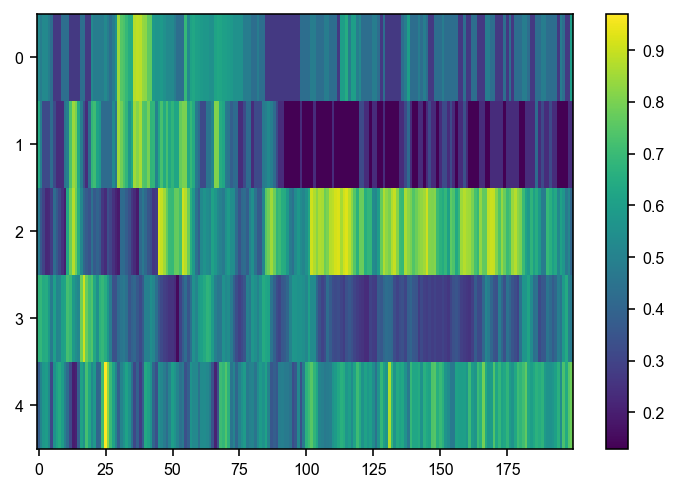

In [39]:
im = plt.imshow(auc_total_all_cell.T, aspect='auto')
plt.colorbar(im)

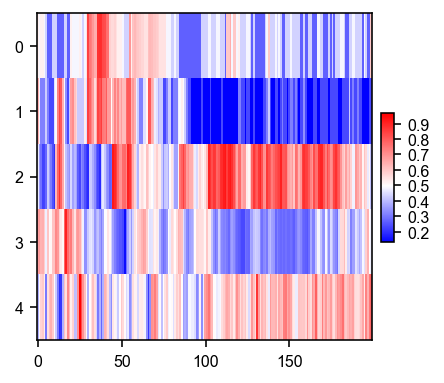

In [41]:
# isort_binge = np.argsort(-auc_total_all_cell[200:250].mean(axis=0))

# isort = np.argsort(-auc_total_all_cell[10:30].mean(axis=0))

elev_min = np.min(np.min(auc_total_all_cell))
elev_max = np.max(np.max(auc_total_all_cell))
mid_val=0.5

fig, ax = plt.subplots(figsize=[3,3])

# auROC for Milk neurons (sort with milk and water [ax0,ax2])

im = ax.imshow(auc_total_all_cell.T,aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.03, 0.3])
fig.colorbar(im, cax=cbar_ax,shrink=0.8)


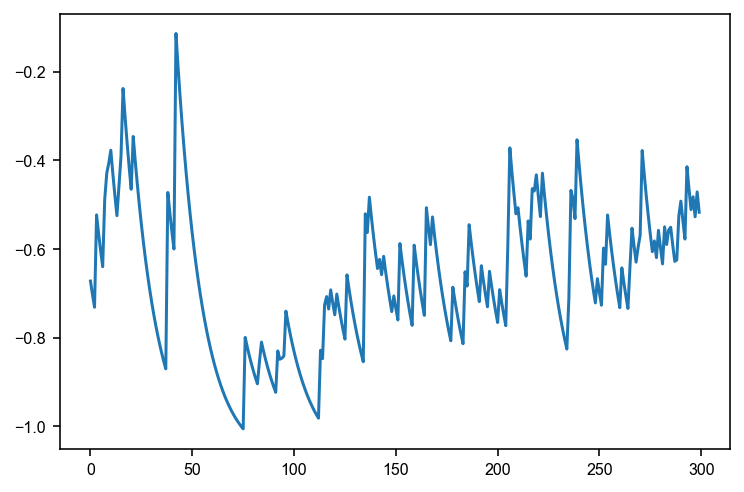

In [29]:
PSTH_trace.mean(axis=1).plot()